In [ ]:
# Install required packages
!pip install scikit-learn

import os
import shutil
import random
import zipfile
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Download the dataset from Google Drive using gdown
import gdown

# Extract the file ID from your Google Drive link
file_id = '17fweRbRqUfirCzbZXgZ8TbK1_Ae1aCIM'

# Try multiple download methods
print("Downloading dataset...")
try:
    # Method 1: Direct download
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, 'dataset.zip', quiet=False)
    print("Download successful!")
except Exception as e:
    print(f"Method 1 failed: {e}")
    try:
        # Method 2: Using gdown with fuzzy matching
        url = f'https://drive.google.com/file/d/{file_id}/view?usp=sharing'
        gdown.download(url, 'dataset.zip', quiet=False, fuzzy=True)
        print("Download successful with fuzzy matching!")
    except Exception as e2:
        print(f"Method 2 failed: {e2}")
        print("Please manually upload your dataset to Colab:")
        print("1. Click on the folder icon in the left sidebar")
        print("2. Click 'Upload' and select your dataset zip file")
        print("3. Rename the uploaded file to 'dataset.zip'")
        print("4. Then run the rest of the code")

        # Check if file was manually uploaded
        if not os.path.exists('dataset.zip'):
            print("Waiting for manual upload... Please upload 'dataset.zip' and rerun this cell.")
            exit()

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

# List contents to understand the structure
print("Dataset contents:")
for root, dirs, files in os.walk('/content/'):
    level = root.replace('/content/', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f'{subindent}{file}')
    if len(files) > 5:
        print(f'{subindent}... and {len(files) - 5} more files')

# Define paths based on the extracted folder structure
# From the output above, we can see the structure is "Label and images/all_images" and "Label and images/labels"
image_dir = '/content/Label and images/all_images'
label_dir = '/content/Label and images/labels'

# Check if directories exist and list some contents
if os.path.exists(image_dir):
    print(f"Images directory found: {len(os.listdir(image_dir))} files")
    print("Sample image files:", os.listdir(image_dir)[:5])
else:
    print(f"Images directory not found at {image_dir}")
    print("Available directories:", [d for d in os.listdir('/content/') if os.path.isdir(os.path.join('/content/', d))])

if os.path.exists(label_dir):
    print(f"Labels directory found: {len(os.listdir(label_dir))} files")
    print("Sample label files:", os.listdir(label_dir)[:5])
else:
    print(f"Labels directory not found at {label_dir}")

# Define output directories
output_dirs = {
    'train': ('/content/dataset/train/images', '/content/dataset/train/labels'),
    'val': ('/content/dataset/val/images', '/content/dataset/val/labels'),
    'test': ('/content/dataset/test/images', '/content/dataset/test/labels')
}

# Create output directories
print("Creating output directories...")
for dir_type in output_dirs.values():
    for path in dir_type:
        os.makedirs(path, exist_ok=True)
        print(f"Created: {path}")

# Collect all image-label pairs, assuming matching filenames
print("Collecting image-label pairs...")
file_pairs = []

# Check for different image extensions
image_extensions = ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']
for ext in image_extensions:
    pairs = [(f, f.rsplit('.', 1)[0] + '.txt') for f in os.listdir(image_dir) if f.endswith(ext)]
    file_pairs.extend(pairs)

print(f"Found {len(file_pairs)} potential image-label pairs")

# Group by class for equal distribution
print("Grouping by class...")
class_map = defaultdict(list)
valid_pairs = []

for img_file, lbl_file in file_pairs:
    label_path = os.path.join(label_dir, lbl_file)
    if os.path.exists(label_path):
        try:
            with open(label_path, 'r') as f:
                classes = set()
                for line in f:
                    line = line.strip()
                    if line:
                        class_id = line.split()[0]
                        classes.add(class_id)

                if classes:  # Only add if we found valid classes
                    valid_pairs.append((img_file, lbl_file))
                    for cls in classes:
                        class_map[cls].append((img_file, lbl_file))
        except Exception as e:
            print(f"Error reading {label_path}: {e}")
    else:
        print(f"Label file not found: {label_path}")

print(f"Valid image-label pairs: {len(valid_pairs)}")
print(f"Classes found: {list(class_map.keys())}")
print(f"Class distribution: {[(cls, len(items)) for cls, items in class_map.items()]}")

if not valid_pairs:
    print("No valid pairs found! Please check your directory structure and file paths.")
    exit()

# Balance class distributions and remove duplicates
print("Balancing class distributions...")
final_files = []
for cls, items in class_map.items():
    random.shuffle(items)
    final_files.extend(items)

# Remove duplicates while preserving order
seen = set()
unique_files = []
for item in final_files:
    if item not in seen:
        seen.add(item)
        unique_files.append(item)

final_files = unique_files
print(f"Final dataset size: {len(final_files)} image-label pairs")

# Set random seed for reproducible results
random.seed(42)
random.shuffle(final_files)

# Split the dataset: 75% train, 15% val, 10% test
train_val, test = train_test_split(final_files, test_size=0.10, random_state=42)
train, val = train_test_split(train_val, test_size=0.15 / 0.90, random_state=42)  # 15% of total

print(f"Dataset split:")
print(f"Train: {len(train)} pairs ({len(train)/len(final_files)*100:.1f}%)")
print(f"Val: {len(val)} pairs ({len(val)/len(final_files)*100:.1f}%)")
print(f"Test: {len(test)} pairs ({len(test)/len(final_files)*100:.1f}%)")

# Helper function to copy files
def copy_files(pairs, subset):
    img_dest, lbl_dest = output_dirs[subset]
    print(f"Copying {len(pairs)} pairs to {subset} set...")

    for i, (img_file, lbl_file) in enumerate(pairs):
        try:
            # Copy image file
            src_img = os.path.join(image_dir, img_file)
            dst_img = os.path.join(img_dest, img_file)
            shutil.copy2(src_img, dst_img)

            # Copy label file
            src_lbl = os.path.join(label_dir, lbl_file)
            dst_lbl = os.path.join(lbl_dest, lbl_file)
            shutil.copy2(src_lbl, dst_lbl)

            if (i + 1) % 100 == 0:
                print(f"  Copied {i + 1}/{len(pairs)} files...")

        except Exception as e:
            print(f"Error copying {img_file}: {e}")

    print(f"Completed copying {subset} set")

# Copy files to respective directories
print("Starting file copying process...")
copy_files(train, 'train')
copy_files(val, 'val')
copy_files(test, 'test')

# Verify the split
print("\nDataset split verification:")
for subset, (img_dir, lbl_dir) in output_dirs.items():
    img_count = len(os.listdir(img_dir))
    lbl_count = len(os.listdir(lbl_dir))
    print(f"{subset.capitalize()}: {img_count} images, {lbl_count} labels")

print("\nDataset split complete! ✅")
print("Your dataset is now ready for training.")

# Optional: Create a dataset.yaml file for YOLO training
yaml_content = f"""
# Dataset configuration for YOLO
path: /content/dataset  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images      # val images (relative to 'path')
test: test/images    # test images (relative to 'path')

# Classes (you may need to adjust this based on your actual classes)
nc: {len(class_map)}  # number of classes
names: {list(class_map.keys())}  # class names
"""

with open('/content/dataset/dataset.yaml', 'w') as f:
    f.write(yaml_content)

print("Created dataset.yaml configuration file")
print("Dataset structure:")
print("/content/dataset/")
print("├── train/")
print("│   ├── images/")
print("│   └── labels/")
print("├── val/")
print("│   ├── images/")
print("│   └── labels/")
print("├── test/")
print("│   ├── images/")
print("│   └── labels/")
print("└── dataset.yaml")

Downloading...
From (original): https://drive.google.com/uc?id=17fweRbRqUfirCzbZXgZ8TbK1_Ae1aCIM
From (redirected): https://drive.google.com/uc?id=17fweRbRqUfirCzbZXgZ8TbK1_Ae1aCIM&confirm=t&uuid=f2361014-e4d7-4095-8a64-348118245f0e
To: /content/dataset.zip
100%|██████████| 4.65G/4.65G [00:38<00:00, 122MB/s]


Download successful!
Extracting dataset...
Dataset contents:
/
  dataset.zip
.config/
  hidden_gcloud_config_universe_descriptor_data_cache_configs.db
  active_config
  .last_update_check.json
  gce
  .last_opt_in_prompt.yaml
  ... and 3 more files
  configurations/
    config_default
  logs/
    2025.05.23/
      13.38.11.844188.log
      13.38.50.979302.log
      13.38.32.731517.log
      13.38.40.911008.log
      13.38.42.097421.log
      ... and 1 more files
Label and images/
  labels/
    Rice___Neck_Blast_09289.txt
    Rice___Leaf_Blast_08902.txt
    Rice___Brown_Spot_06615.txt
    Potato___Late_Blight_05843.txt
    Wheat___Brown_Rust_10786.txt
    ... and 13319 more files
  all_images/
    Potato___Early_Blight_04428.jpg
    Rice___Healthy_06927.jpg
    Corn___Healthy_02316.jpg
    Rice___Neck_Blast_09469.jpg
    Rice___Neck_Blast_09992.jpg
    ... and 13319 more files
dataset/
  test/
    labels/
    images/
  train/
    labels/
    images/
  val/
    labels/
    images/
sample

🌱 Initializing YOLOv8 Plant Disease Detection Trainer
Using device: cuda
GPU: Tesla T4

🎯 Training Configuration:
   - Model: YOLOv8m (Medium)
   - Epochs: 25
   - Batch Size: 16
   - Image Size: 640x640
   - Learning Rate: 0.01
🚀 Starting YOLOv8 Plant Disease Detection Training
📋 Configuration:
   - Model: YOLOv8M
   - Epochs: 25
   - Batch Size: 16
   - Image Size: 640
   - Learning Rate: 0.01
   - Device: cuda
✅ Created dataset configuration: /content/dataset/dataset.yaml
📂 TRAIN: 9992 images, 9992 labels
📂 VAL: 1999 images, 1999 labels
📂 TEST: 1333 images, 1333 labels
📊 Total dataset: 13324 images, 13324 labels
📥 Loading YOLOv8 M model...

🔥 Starting training...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=5, cls=0.5, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cu

train: Scanning /content/dataset/train/labels.cache... 9991 images, 0 backgrounds, 1 corrupt: 100%|██████████| 9992/9992 [00:00<?, ?it/s]

train: /content/dataset/train/images/Sugarcane___Healthy_10184.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10186.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10187.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10188.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10189.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10190.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10191.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10192.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10193.jpg: corrupt JPEG restored and saved
train: /content/dataset/train/images/Sugarcane___Healthy_10195.jpg: corrupt JPEG restored and saved


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 343.7±286.7 MB/s, size: 1765.1 KB)


val: Scanning /content/dataset/val/labels.cache... 1999 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1999/1999 [00:00<?, ?it/s]

val: /content/dataset/val/images/Sugarcane___Healthy_10183.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10196.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10197.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10212.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10223.jpg: corrupt JPEG restored and saved


Plotting labels to plant_disease_detection_colab/yolov8m_plant_disease_25epochs/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to plant_disease_detection_colab/yolov8m_plant_disease_25epochs
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      14.2G     0.2594      1.447      1.025         20        544: 100%|██████████| 625/625 [06:42<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

                   all       1999       1999      0.724      0.896      0.868      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      14.2G     0.1941     0.7081     0.9355         23        960: 100%|██████████| 625/625 [07:15<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.29it/s]

                   all       1999       1999      0.689      0.876      0.863      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      14.5G     0.2383     0.7492     0.9425         23        640: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.29it/s]

                   all       1999       1999      0.675      0.847      0.842       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      13.8G     0.2402     0.7716     0.9413         19        832: 100%|██████████| 625/625 [07:20<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:47<00:00,  1.32it/s]

                   all       1999       1999      0.669      0.837      0.843      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      13.7G     0.2095     0.6967     0.9225         17        384: 100%|██████████| 625/625 [07:24<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.30it/s]

                   all       1999       1999      0.747      0.887      0.913      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        14G     0.1867     0.6318      0.913         23        928: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]

                   all       1999       1999      0.822      0.829      0.873      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      13.7G     0.1644     0.5758     0.9056         24        384: 100%|██████████| 625/625 [07:21<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:49<00:00,  1.28it/s]

                   all       1999       1999      0.787      0.879      0.906        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      14.3G     0.1499     0.5496     0.9016         27        640: 100%|██████████| 625/625 [07:26<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:45<00:00,  1.37it/s]

                   all       1999       1999       0.84      0.918      0.935      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      14.1G     0.1304     0.5251     0.8937         26        480: 100%|██████████| 625/625 [07:27<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:45<00:00,  1.38it/s]

                   all       1999       1999      0.882      0.906      0.929      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      14.1G     0.1248     0.4998     0.8936         22        320: 100%|██████████| 625/625 [07:18<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.31it/s]


                   all       1999       1999      0.867        0.9      0.938      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      13.6G     0.1132     0.4683     0.8899         21        768: 100%|██████████| 625/625 [07:34<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]

                   all       1999       1999      0.878      0.951      0.958      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      13.6G      0.107     0.4578     0.8881         21        800: 100%|██████████| 625/625 [07:09<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:49<00:00,  1.28it/s]


                   all       1999       1999      0.851      0.945      0.951      0.948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      13.9G    0.09373     0.4255     0.8863         17        640: 100%|██████████| 625/625 [07:03<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:47<00:00,  1.34it/s]

                   all       1999       1999      0.898      0.927      0.959      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      14.5G    0.08638     0.4007     0.8834         19        832: 100%|██████████| 625/625 [07:20<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:47<00:00,  1.33it/s]

                   all       1999       1999      0.905      0.952      0.961      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      14.5G    0.07787     0.3916     0.8829         24        800: 100%|██████████| 625/625 [07:03<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.29it/s]

                   all       1999       1999      0.913      0.945      0.966      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      14.6G    0.07196     0.3707     0.8815         17        512: 100%|██████████| 625/625 [07:17<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:47<00:00,  1.32it/s]

                   all       1999       1999      0.928      0.925      0.964      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      14.5G    0.06534     0.3494     0.8812         26        544: 100%|██████████| 625/625 [07:13<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]

                   all       1999       1999      0.925      0.949      0.973      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      14.6G    0.05839     0.3391     0.8778         16        832: 100%|██████████| 625/625 [07:27<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:46<00:00,  1.35it/s]


                   all       1999       1999      0.929      0.956      0.974      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      14.3G    0.05233     0.3205      0.878         19        384: 100%|██████████| 625/625 [07:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:48<00:00,  1.31it/s]

                   all       1999       1999      0.929      0.954      0.974      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      14.4G    0.04676     0.3078     0.8783         25        768: 100%|██████████| 625/625 [07:29<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:53<00:00,  1.19it/s]

                   all       1999       1999      0.958      0.946      0.977      0.977


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25        14G    0.05574     0.2084     0.8777          7        736: 100%|██████████| 625/625 [06:30<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:52<00:00,  1.19it/s]

                   all       1999       1999      0.944      0.959      0.977      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      14.5G    0.04863      0.178     0.8701          7        544: 100%|██████████| 625/625 [06:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:50<00:00,  1.26it/s]

                   all       1999       1999      0.934      0.957      0.976      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      13.5G    0.04528     0.1729     0.8651          7        608: 100%|██████████| 625/625 [06:51<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:49<00:00,  1.27it/s]

                   all       1999       1999      0.944      0.959      0.979      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      14.5G    0.04269     0.1556     0.8648          7        448: 100%|██████████| 625/625 [06:48<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:52<00:00,  1.20it/s]

                   all       1999       1999      0.943      0.962       0.98       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      14.2G    0.03904     0.1519      0.869          7        736: 100%|██████████| 625/625 [06:50<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

                   all       1999       1999      0.958      0.949       0.98       0.98



25 epochs completed in 3.364 hours.
Optimizer stripped from plant_disease_detection_colab/yolov8m_plant_disease_25epochs/weights/last.pt, 52.0MB
Optimizer stripped from plant_disease_detection_colab/yolov8m_plant_disease_25epochs/weights/best.pt, 52.0MB

Validating plant_disease_detection_colab/yolov8m_plant_disease_25epochs/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,849,603 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


                   all       1999       1999      0.958      0.949       0.98       0.98
    Corn___Common_Rust        177        177      0.998          1      0.995      0.995
 Corn___Gray_Leaf_Spot         74         74      0.939      0.825      0.961      0.961
        Corn___Healthy        172        172      0.998          1      0.995      0.995
Corn___Northern_Leaf_Blight        140        140      0.932      0.971      0.986      0.986
 Potato___Early_Blight        144        144          1      0.996      0.995      0.995
      Potato___Healthy         21         21      0.844          1      0.995      0.995
  Potato___Late_Blight        137        137      0.993      0.994      0.995      0.995
     Rice___Brown_Spot        107        107      0.925       0.72      0.899      0.899
        Rice___Healthy        224        224      0.891      0.951      0.947      0.947
     Rice___Leaf_Blast        159        159      0.899       0.84      0.936      0.936
     Rice___Neck

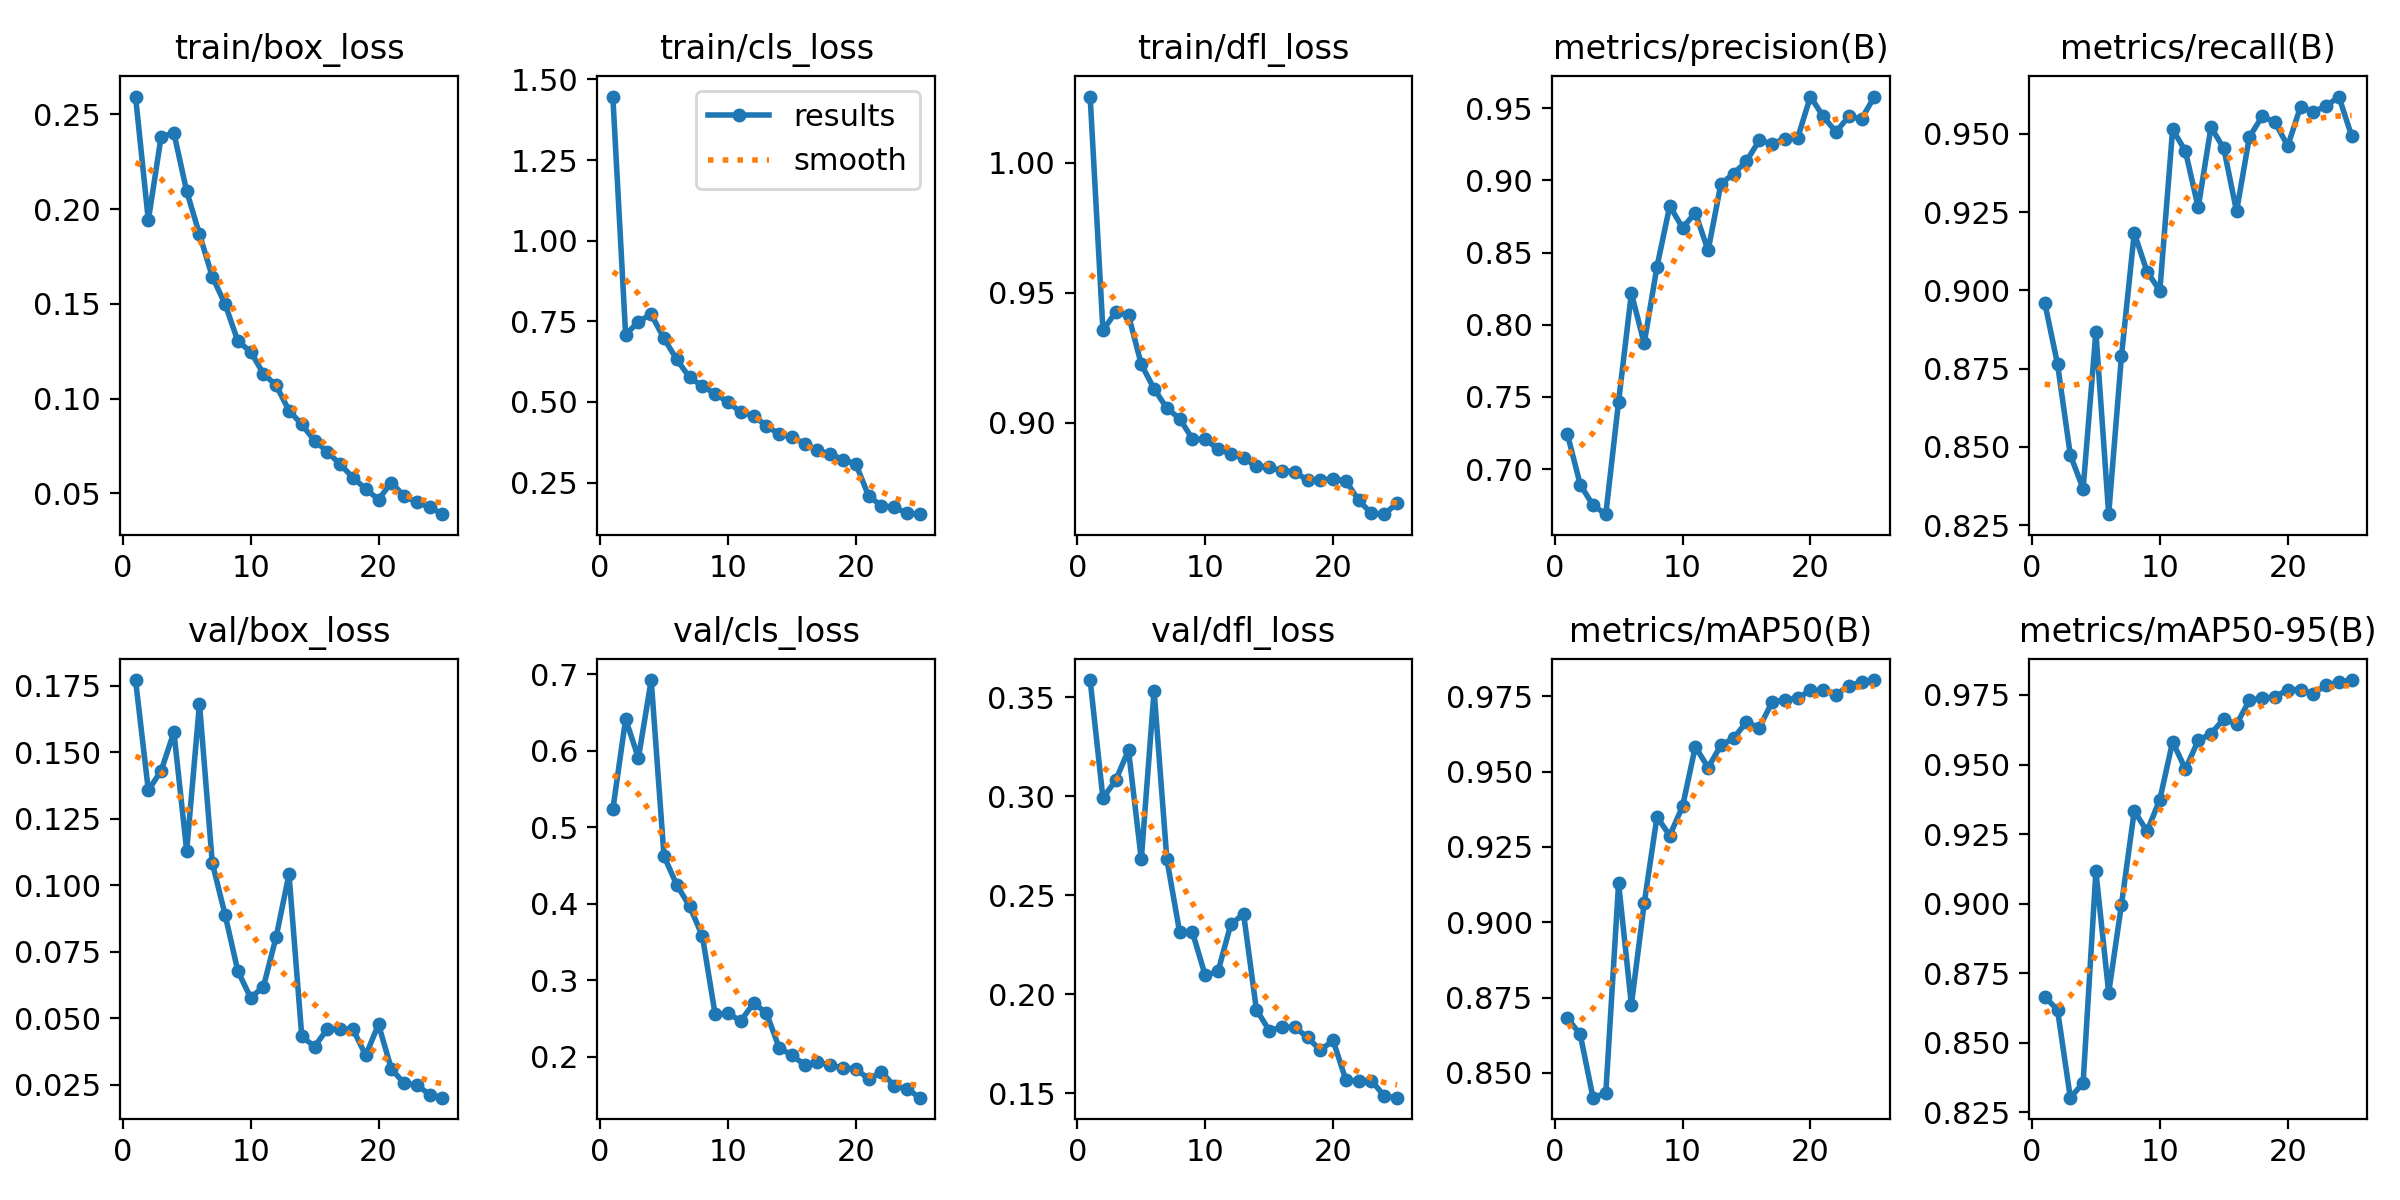


📊 confusion_matrix.png:


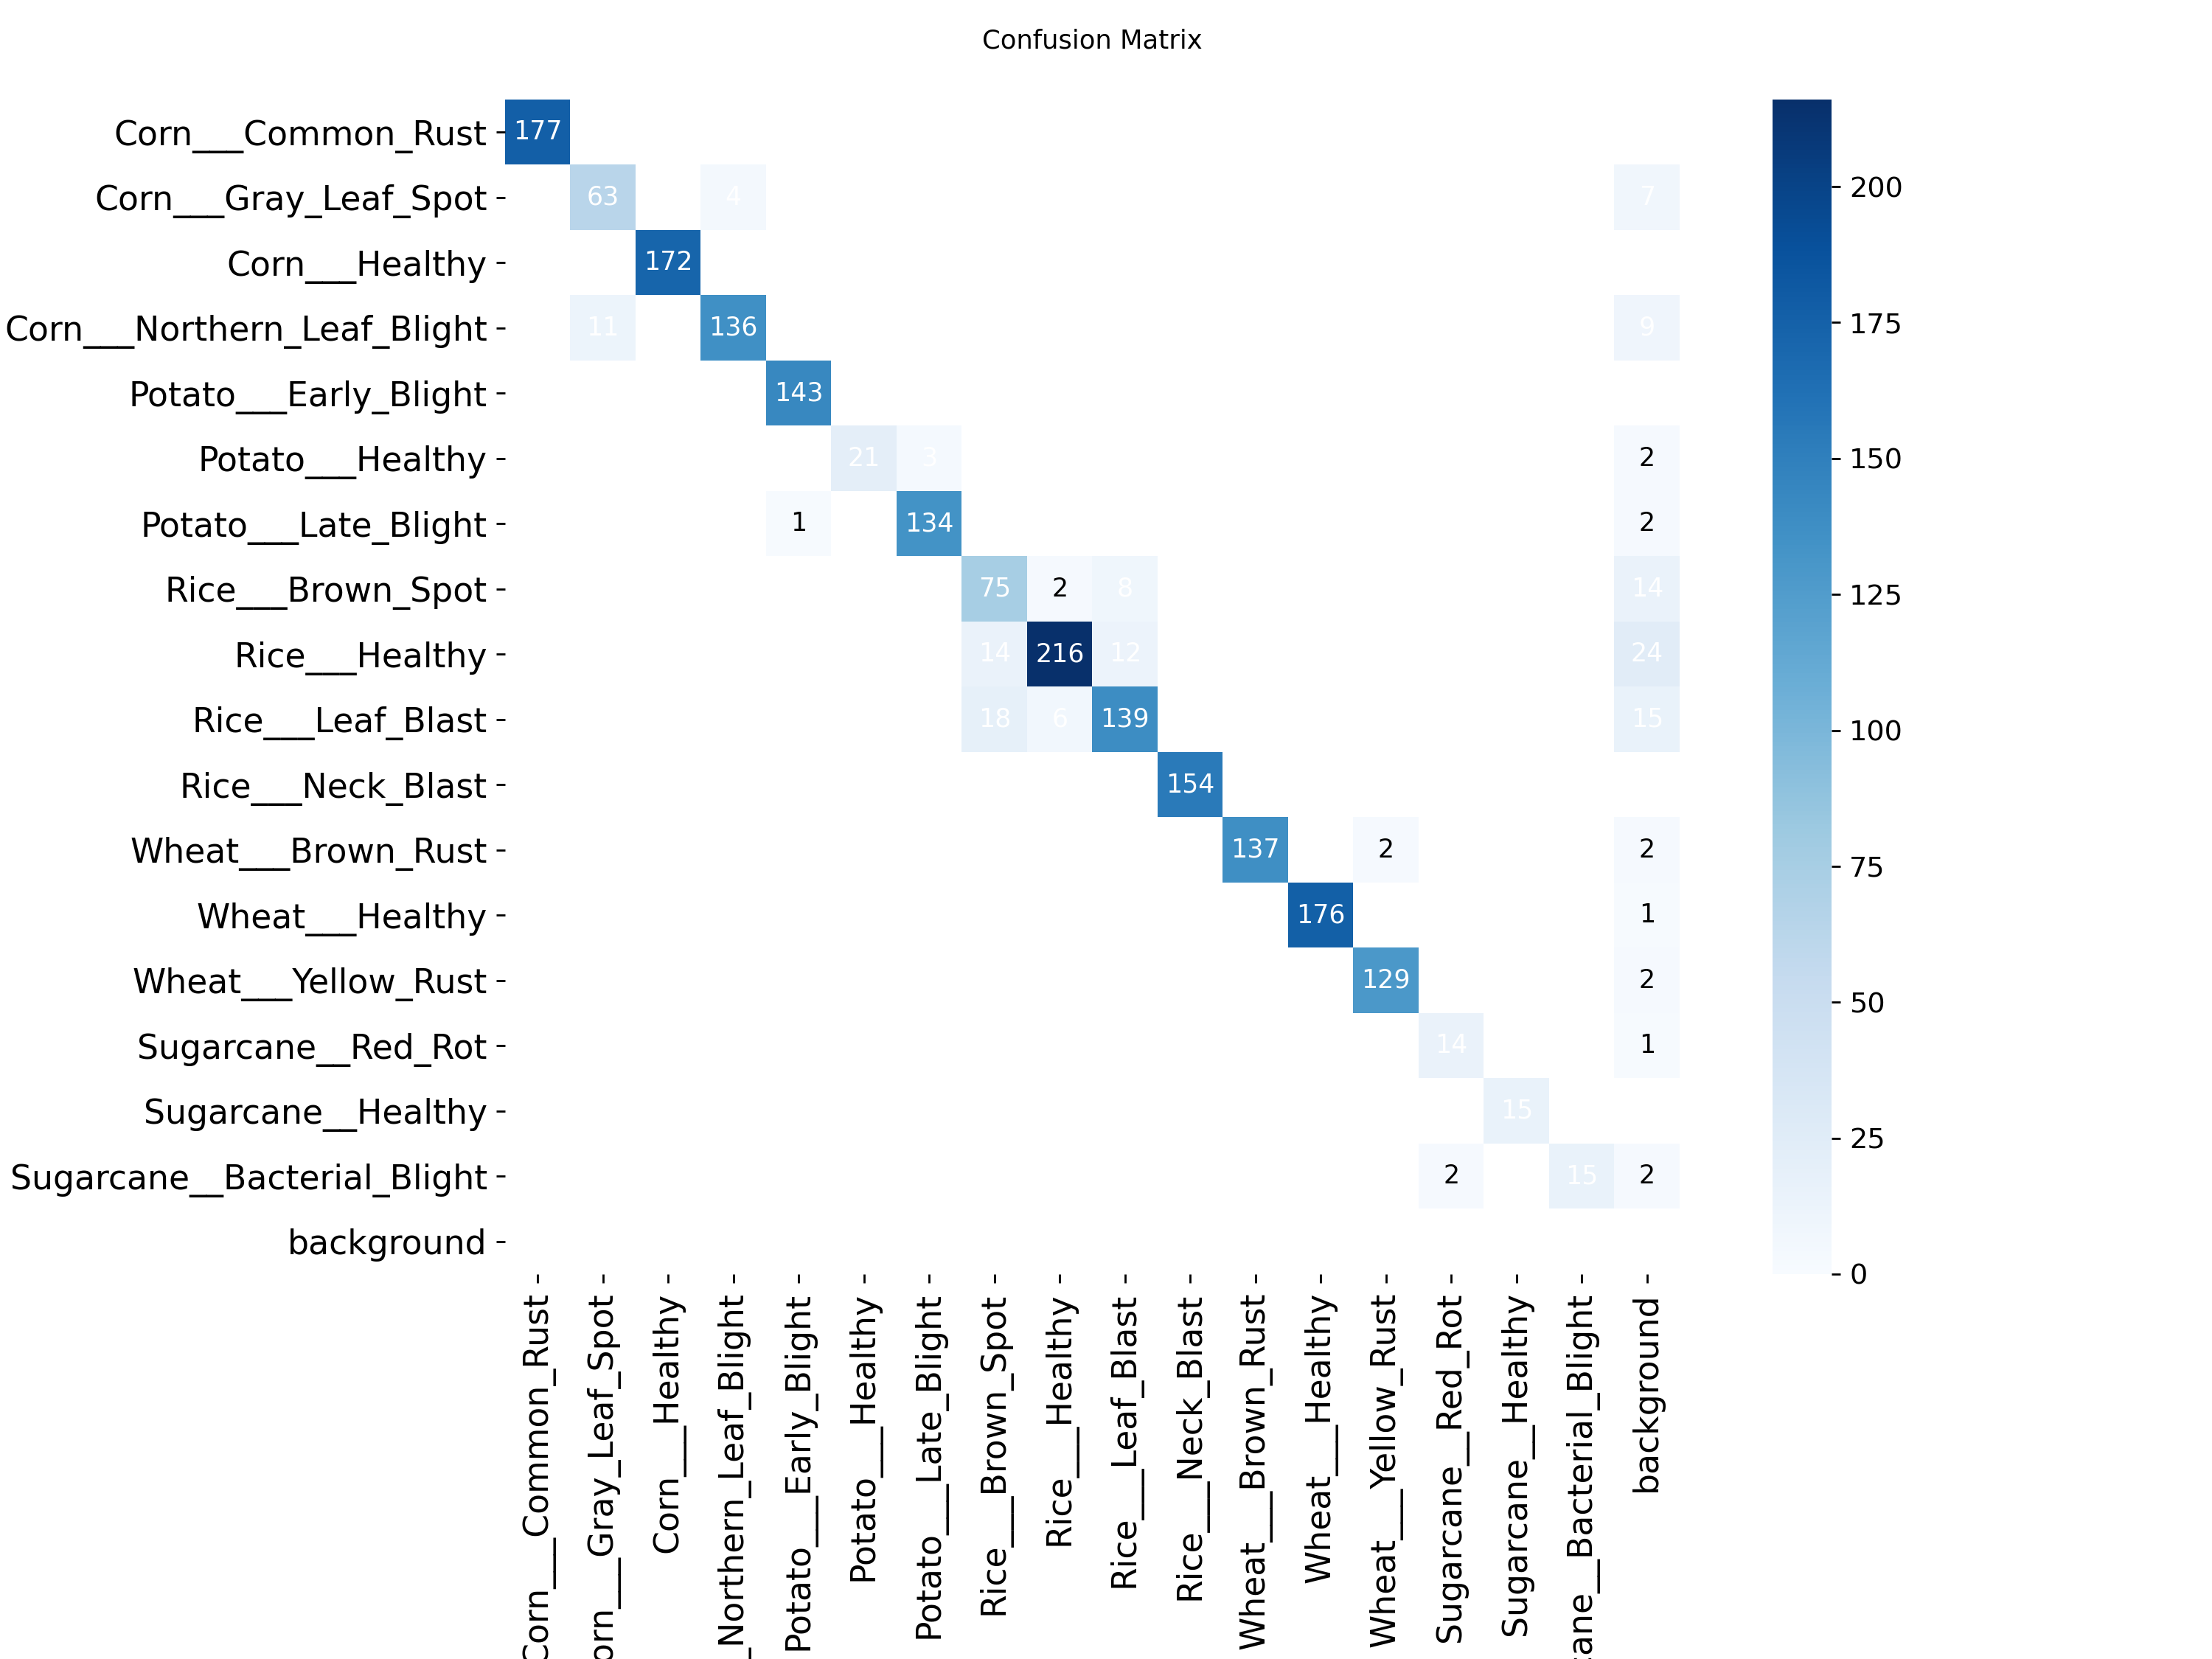


🎊 TRAINING COMPLETED SUCCESSFULLY!

🔍 Running validation on best model...
🔍 Validating model: plant_disease_detection_colab/yolov8m_plant_disease_25epochs/weights/best.pt
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,849,603 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 772.8±552.7 MB/s, size: 26.4 KB)


val: Scanning /content/dataset/val/labels.cache... 1999 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1999/1999 [00:00<?, ?it/s]

val: /content/dataset/val/images/Sugarcane___Healthy_10183.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10196.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10197.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10212.jpg: corrupt JPEG restored and saved
val: /content/dataset/val/images/Sugarcane___Healthy_10223.jpg: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


                   all       1999       1999       0.96      0.952      0.981      0.981
    Corn___Common_Rust        177        177      0.998          1      0.995      0.995
 Corn___Gray_Leaf_Spot         74         74      0.939       0.83      0.961      0.961
        Corn___Healthy        172        172      0.998          1      0.995      0.995
Corn___Northern_Leaf_Blight        140        140      0.923      0.971      0.986      0.986
 Potato___Early_Blight        144        144          1      0.996      0.995      0.995
      Potato___Healthy         21         21      0.842          1      0.995      0.995
  Potato___Late_Blight        137        137      0.993      0.994      0.995      0.995
     Rice___Brown_Spot        107        107      0.928      0.727        0.9        0.9
        Rice___Healthy        224        224      0.885      0.955      0.947      0.947
     Rice___Leaf_Blast        159        159      0.898      0.843      0.936      0.936
     Rice___Neck

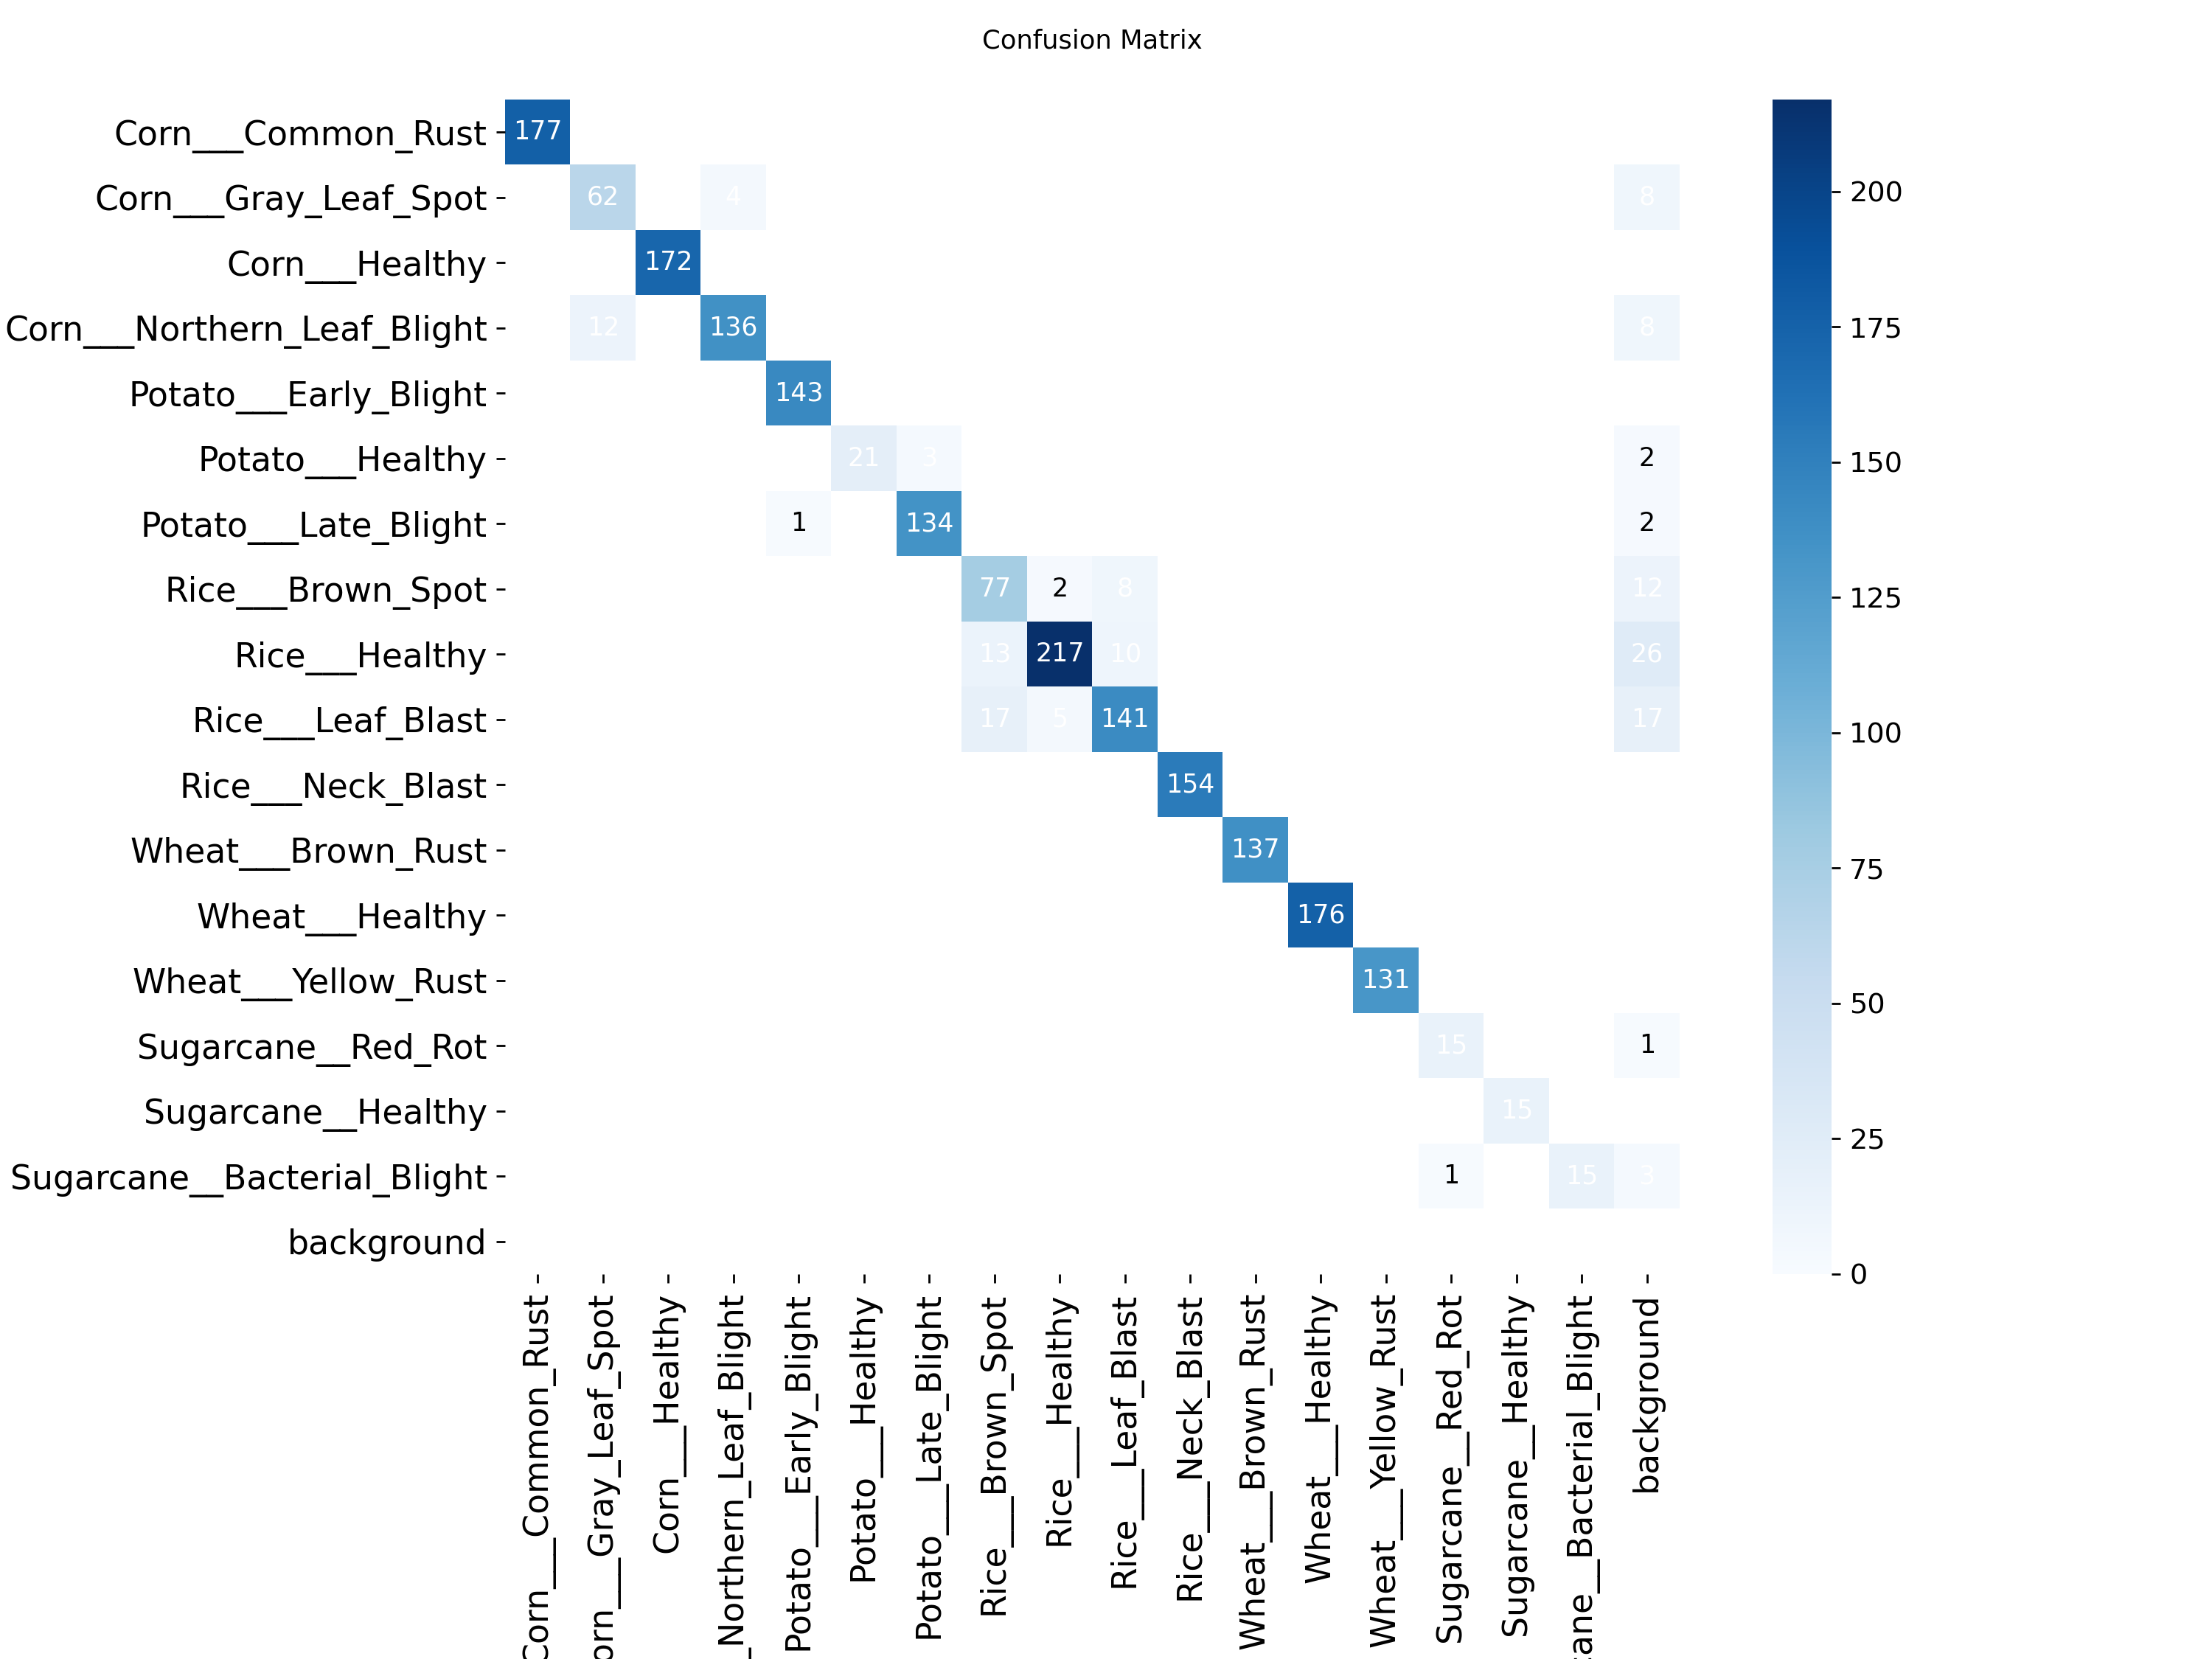


🔮 Running sample predictions...
🔮 Running predictions on sample images...
📸 Predicting on 3 sample images...

🖼️  Predicting: Rice___Neck_Blast_09469.jpg

image 1/1 /content/dataset/test/images/Rice___Neck_Blast_09469.jpg: 640x640 1 Rice___Neck_Blast, 36.4ms
Speed: 6.7ms preprocess, 36.4ms inference, 13.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


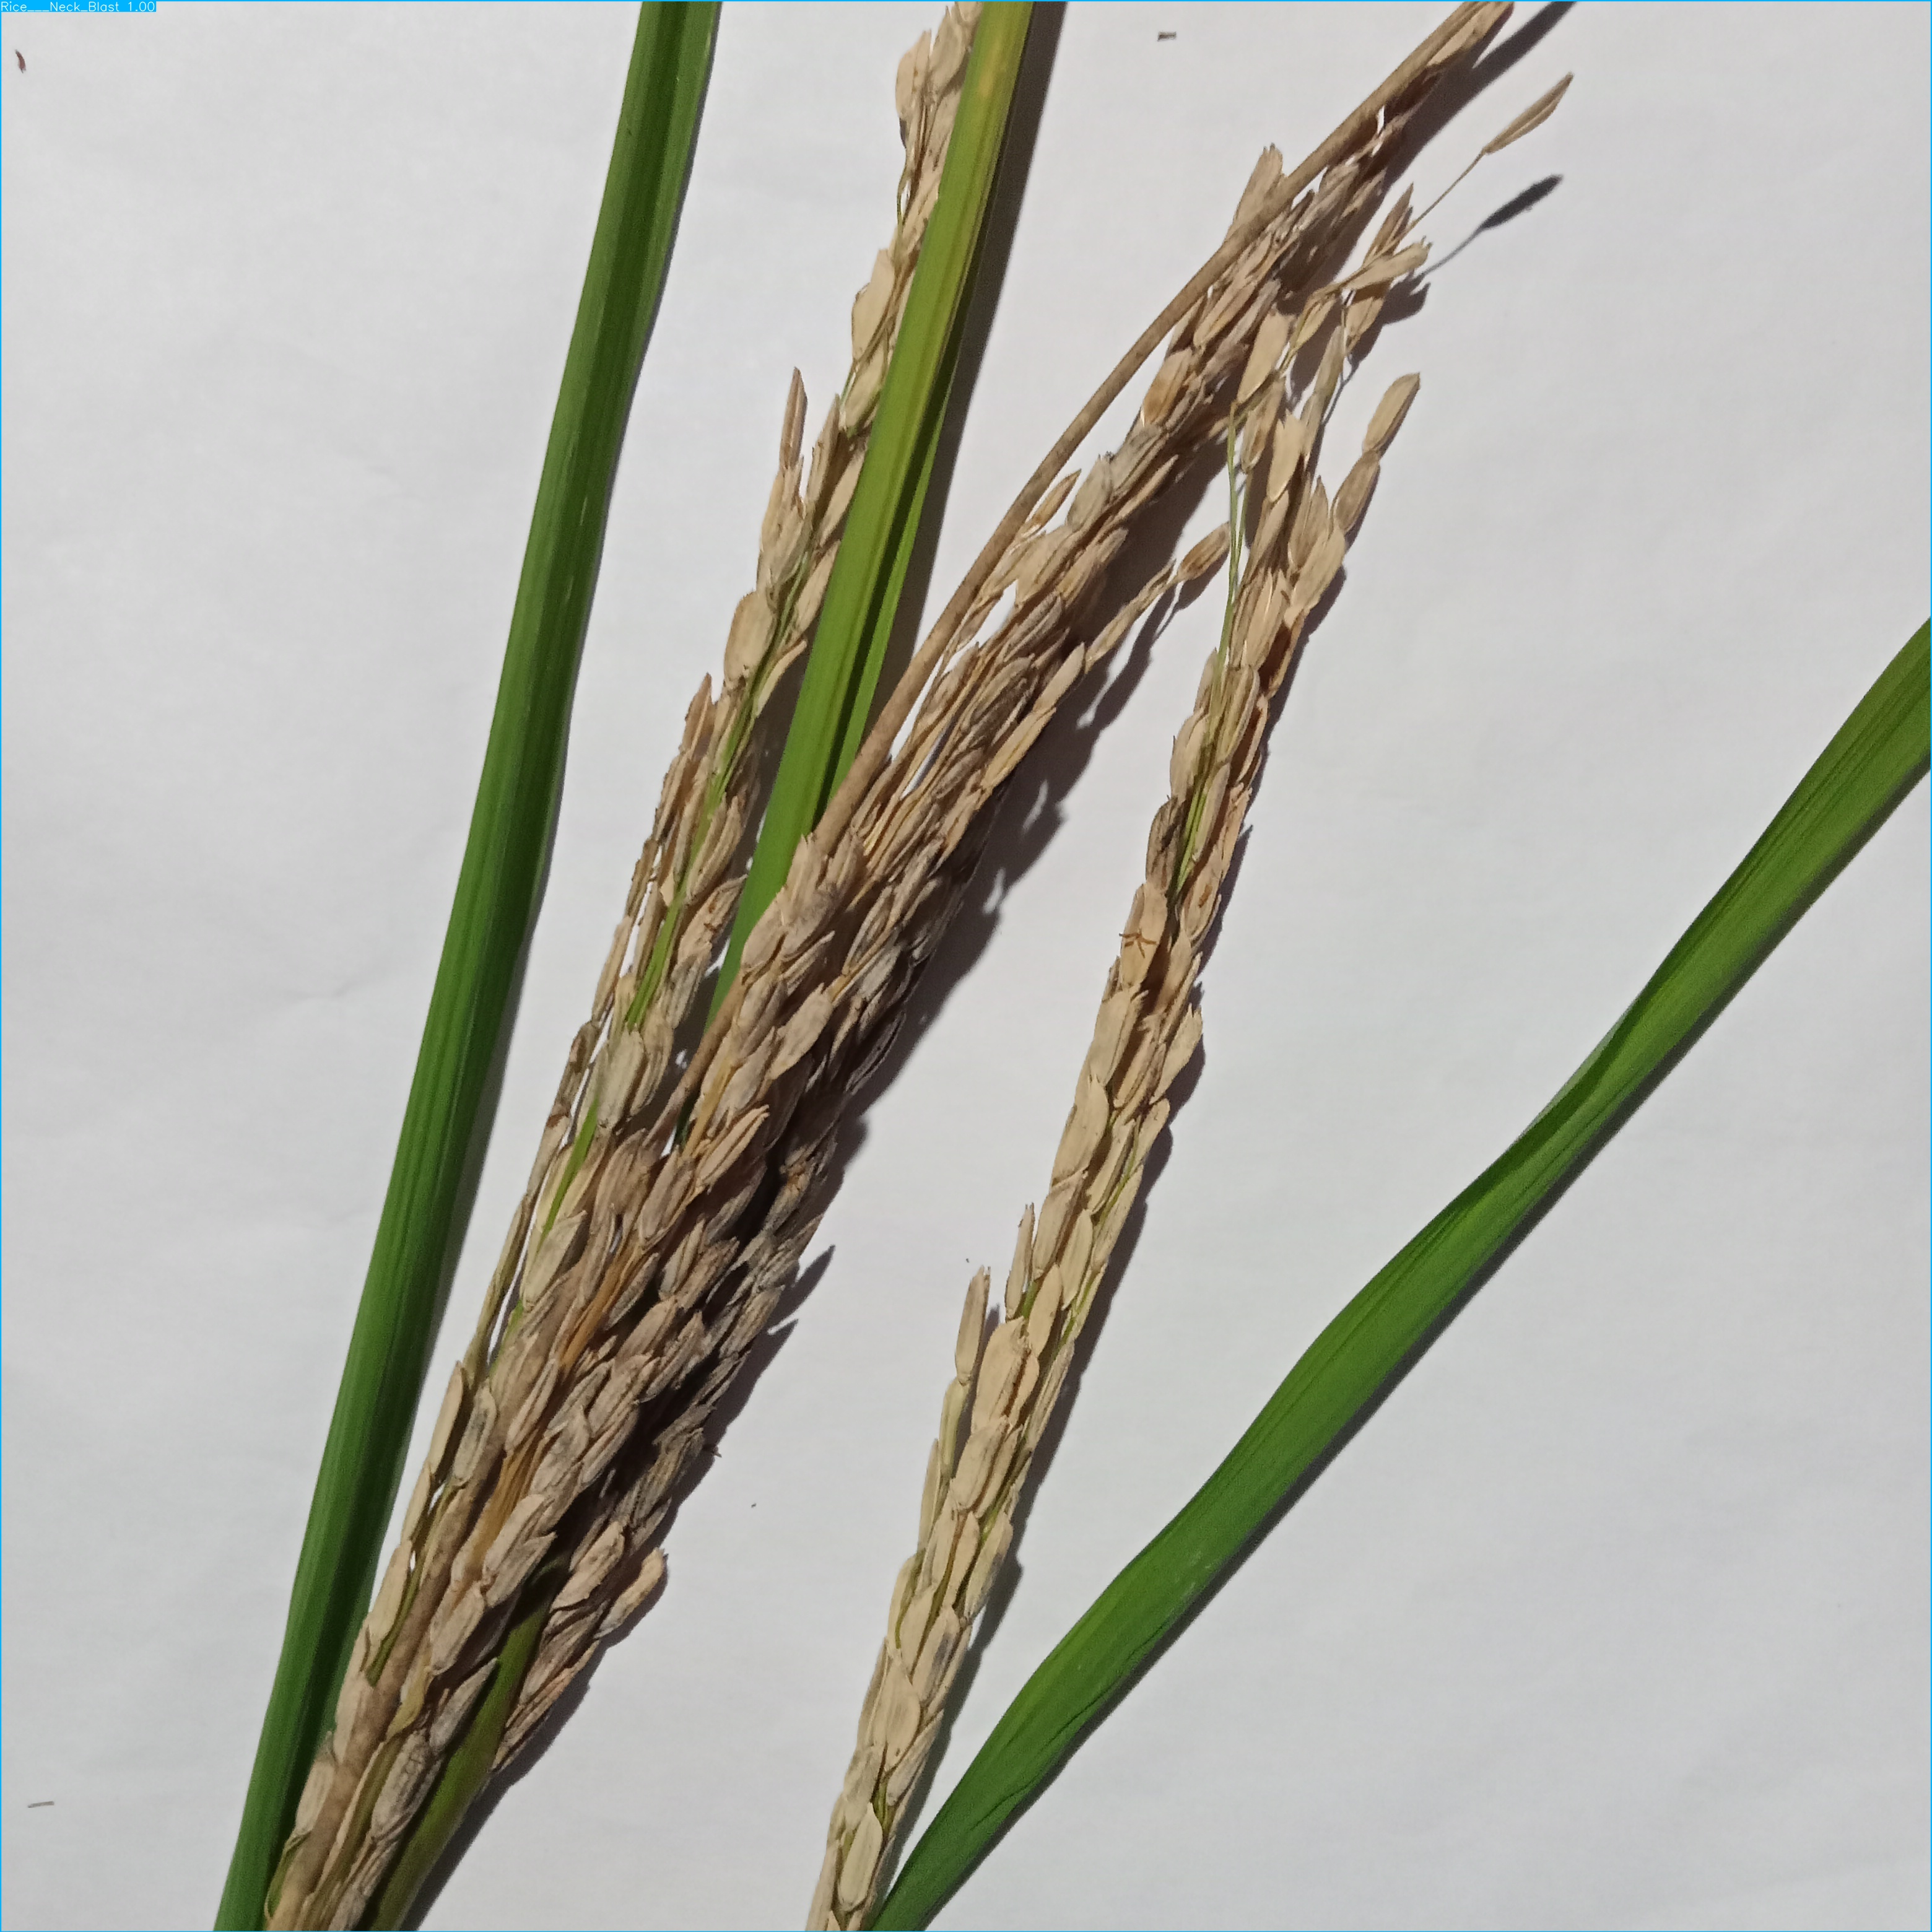


🖼️  Predicting: Corn___Healthy_02369.jpg

image 1/1 /content/dataset/test/images/Corn___Healthy_02369.jpg: 640x640 1 Corn___Healthy, 36.4ms
Speed: 3.7ms preprocess, 36.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


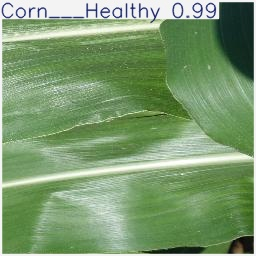


🖼️  Predicting: Rice___Neck_Blast_09850.jpg

image 1/1 /content/dataset/test/images/Rice___Neck_Blast_09850.jpg: 640x640 1 Rice___Neck_Blast, 36.4ms
Speed: 5.4ms preprocess, 36.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


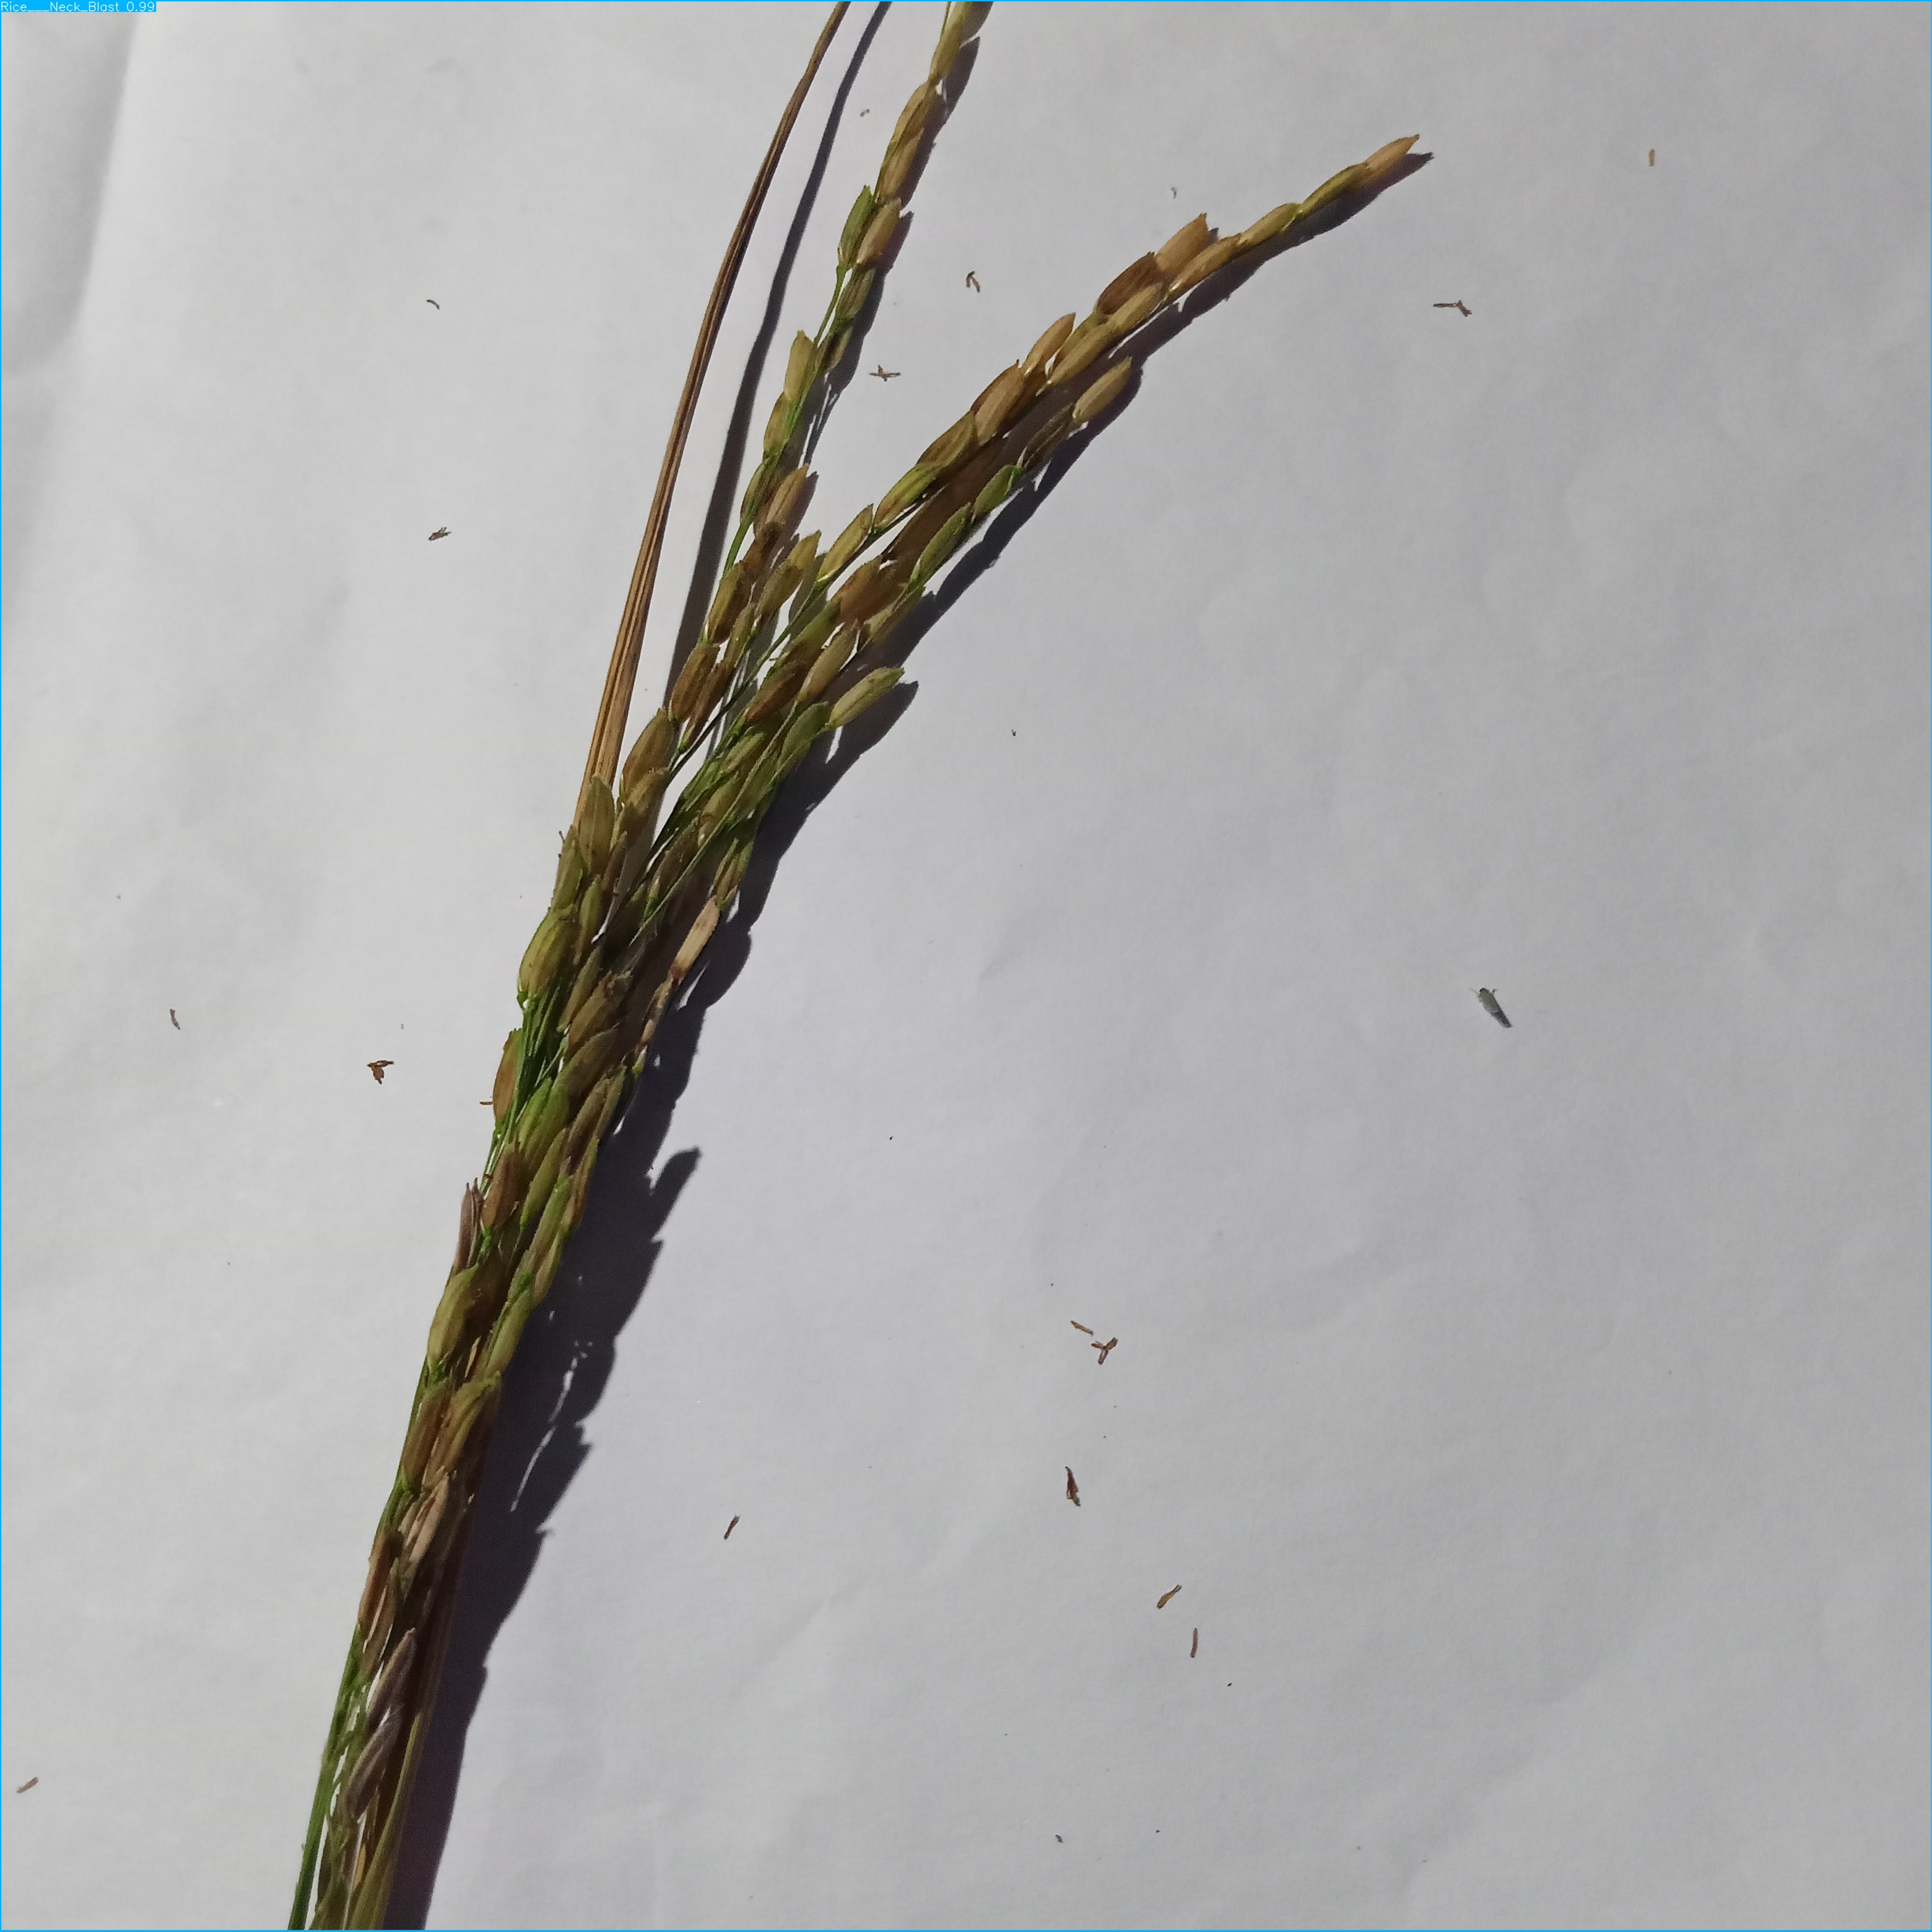


✅ All done! Your trained model is saved at:
📁 plant_disease_detection_colab/yolov8m_plant_disease_25epochs/weights/best.pt
Model summary: 169 layers, 25,866,163 parameters, 0 gradients, 79.1 GFLOPs

🏁 Script execution completed!


In [ ]:
# Install required packages
!pip install ultralytics
!pip install PyYAML

import os
import sys
import yaml
from pathlib import Path
import shutil
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
from IPython.display import Image, display

class YOLOv8PlantDiseaseTrainer:
    def __init__(self, data_path, project_name="plant_disease_detection"):
        self.data_path = Path(data_path)
        self.project_name = project_name
        self.classes = [
            'Corn___Common_Rust',
            'Corn___Gray_Leaf_Spot',
            'Corn___Healthy',
            'Corn___Northern_Leaf_Blight',
            'Potato___Early_Blight',
            'Potato___Healthy',
            'Potato___Late_Blight',
            'Rice___Brown_Spot',
            'Rice___Healthy',
            'Rice___Leaf_Blast',
            'Rice___Neck_Blast',
            'Wheat___Brown_Rust',
            'Wheat___Healthy',
            'Wheat___Yellow_Rust',
            'Sugarcane__Red_Rot',
            'Sugarcane__Healthy',
            'Sugarcane__Bacterial_Blight'
        ]

        # Verify GPU availability
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")
        if self.device == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        else:
            print("⚠️  Warning: GPU not available. Training will be slower on CPU.")

    def create_yaml_config(self):
        """Create YAML configuration file for YOLOv8 training"""
        config = {
            'path': str(self.data_path.absolute()),
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',
            'nc': len(self.classes),
            'names': {i: name for i, name in enumerate(self.classes)}
        }

        config_path = self.data_path / 'dataset.yaml'
        with open(config_path, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)

        print(f"✅ Created dataset configuration: {config_path}")
        return config_path

    def verify_data_structure(self):
        """Verify the data structure matches YOLOv8 requirements"""
        required_dirs = [
            'train/images', 'train/labels',
            'val/images', 'val/labels',
            'test/images', 'test/labels'
        ]

        missing_dirs = []
        for dir_path in required_dirs:
            full_path = self.data_path / dir_path
            if not full_path.exists():
                missing_dirs.append(dir_path)

        if missing_dirs:
            print(f"❌ Warning: Missing directories: {missing_dirs}")
            return False

        # Check if there are images and labels
        total_images = 0
        total_labels = 0
        for split in ['train', 'val', 'test']:
            img_dir = self.data_path / split / 'images'
            label_dir = self.data_path / split / 'labels'

            img_count = len(list(img_dir.glob('*.[jp][pn]g'))) if img_dir.exists() else 0
            label_count = len(list(label_dir.glob('*.txt'))) if label_dir.exists() else 0

            total_images += img_count
            total_labels += label_count

            print(f"📂 {split.upper()}: {img_count} images, {label_count} labels")

        print(f"📊 Total dataset: {total_images} images, {total_labels} labels")
        return True

    def train_model(self,
                   model_size='m',  # Using 'm' for medium as specified
                   epochs=25,       # Changed to 25 epochs
                   batch_size=16,   # Using batch size 16 as specified
                   img_size=640,
                   learning_rate=0.01,
                   patience=15):    # Reduced patience for 25 epochs
        """
        Train YOLOv8 model with specified parameters
        """
        print("🚀 Starting YOLOv8 Plant Disease Detection Training")
        print(f"📋 Configuration:")
        print(f"   - Model: YOLOv8{model_size.upper()}")
        print(f"   - Epochs: {epochs}")
        print(f"   - Batch Size: {batch_size}")
        print(f"   - Image Size: {img_size}")
        print(f"   - Learning Rate: {learning_rate}")
        print(f"   - Device: {self.device}")

        # Create YAML config
        config_path = self.create_yaml_config()

        # Verify data structure
        if not self.verify_data_structure():
            print("❌ Data structure verification failed. Please check your dataset.")
            return None

        # Initialize model
        model_name = f'yolov8{model_size}.pt'
        print(f"📥 Loading YOLOv8 {model_size.upper()} model...")
        model = YOLO(model_name)

        # Training arguments optimized for 25 epochs
        train_args = {
            'data': str(config_path),
            'epochs': epochs,
            'batch': batch_size,
            'imgsz': img_size,
            'lr0': learning_rate,
            'patience': patience,
            'save_period': 5,  # Save every 5 epochs for shorter training
            'project': self.project_name,
            'name': f'yolov8{model_size}_plant_disease_25epochs',
            'device': self.device,
            'workers': 2,  # Reduced for Colab stability
            'exist_ok': True,
            'pretrained': True,
            'optimizer': 'SGD',
            'verbose': True,
            'seed': 42,
            'deterministic': True,
            'cos_lr': True,
            'close_mosaic': 5,  # Close mosaic earlier for shorter training
            'amp': True,  # Mixed precision for faster training
            'fraction': 1.0,
            'multi_scale': True,
            'val': True,
            'plots': True,
            'save_json': True,
            'conf': 0.001,
            'iou': 0.6,
            'max_det': 300,
        }

        print("\n🔥 Starting training...")
        print("=" * 60)

        # Train the model
        try:
            results = model.train(**train_args)
            print("\n🎉 Training completed successfully!")

            # Print training results
            if results:
                print(f"📁 Best model saved at: {results.save_dir}")
                best_model_path = results.save_dir / 'weights' / 'best.pt'
                last_model_path = results.save_dir / 'weights' / 'last.pt'

                print(f"✅ Best model: {best_model_path}")
                print(f"📄 Last model: {last_model_path}")

                # Display training plots if available
                results_dir = results.save_dir
                plot_files = ['results.png', 'confusion_matrix.png', 'val_batch0_pred.png']

                for plot_file in plot_files:
                    plot_path = results_dir / plot_file
                    if plot_path.exists():
                        print(f"\n📊 {plot_file}:")
                        display(Image(filename=str(plot_path)))

            return results

        except Exception as e:
            print(f"❌ Training failed with error: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def validate_model(self, model_path):
        """Validate trained model"""
        print(f"🔍 Validating model: {model_path}")
        try:
            model = YOLO(model_path)
            config_path = self.data_path / 'dataset.yaml'

            # Run validation
            results = model.val(
                data=str(config_path),
                split='val',
                save_json=True,
                conf=0.001,
                iou=0.6,
                max_det=300,
                device=self.device,
                plots=True,
            )

            print("✅ Validation completed!")

            # Display validation results if available
            if hasattr(results, 'save_dir') and results.save_dir:
                val_plots = ['val_batch0_pred.png', 'confusion_matrix.png']
                for plot_file in val_plots:
                    plot_path = Path(results.save_dir) / plot_file
                    if plot_path.exists():
                        print(f"\n📊 Validation {plot_file}:")
                        display(Image(filename=str(plot_path)))

            return results

        except Exception as e:
            print(f"❌ Validation failed: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

    def predict_sample(self, model_path, num_samples=5):
        """Run prediction on sample test images"""
        print(f"🔮 Running predictions on sample images...")
        try:
            model = YOLO(model_path)
            test_img_dir = self.data_path / 'test' / 'images'

            # Get sample images
            test_images = list(test_img_dir.glob('*.[jp][pn]g'))[:num_samples]

            if not test_images:
                print("❌ No test images found!")
                return

            print(f"📸 Predicting on {len(test_images)} sample images...")

            for img_path in test_images:
                print(f"\n🖼️  Predicting: {img_path.name}")

                # Run prediction
                results = model.predict(
                    source=str(img_path),
                    conf=0.25,
                    device=self.device,
                    save=True,
                    show_labels=True,
                    show_conf=True,
                    line_width=2
                )

                # Display results
                for r in results:
                    if r.save_dir:
                        pred_path = Path(r.save_dir) / img_path.name
                        if pred_path.exists():
                            display(Image(filename=str(pred_path)))

        except Exception as e:
            print(f"❌ Prediction failed: {str(e)}")
            import traceback
            traceback.print_exc()

# Initialize the trainer with your dataset
print("🌱 Initializing YOLOv8 Plant Disease Detection Trainer")
print("=" * 60)

# Set up paths
data_path = '/content/dataset'  # Path to your split dataset
trainer = YOLOv8PlantDiseaseTrainer(data_path, "plant_disease_detection_colab")

# Start training with 25 epochs configuration
print("\n🎯 Training Configuration:")
print("   - Model: YOLOv8m (Medium)")
print("   - Epochs: 25")
print("   - Batch Size: 16")
print("   - Image Size: 640x640")
print("   - Learning Rate: 0.01")

# Train the model with 25 epochs
results = trainer.train_model(
    model_size='m',      # YOLOv8m as requested
    epochs=25,           # Changed to 25 epochs
    batch_size=16,       # Batch size 16 as requested
    img_size=640,
    learning_rate=0.01,
    patience=15          # Reduced patience for shorter training
)

# If training is successful, run validation and sample predictions
if results:
    print("\n" + "="*60)
    print("🎊 TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)

    best_model_path = results.save_dir / 'weights' / 'best.pt'

    # Run validation
    print("\n🔍 Running validation on best model...")
    trainer.validate_model(str(best_model_path))

    # Run sample predictions
    print("\n🔮 Running sample predictions...")
    trainer.predict_sample(str(best_model_path), num_samples=3)

    print(f"\n✅ All done! Your trained model is saved at:")
    print(f"📁 {best_model_path}")

    # Display model info
    model = YOLO(str(best_model_path))
    model.info()

else:
    print("\n❌ Training failed. Please check the error messages above.")

print("\n🏁 Script execution completed!")